<a href="https://colab.research.google.com/github/arvinsingh/IDS/blob/master/IDS3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!ls drive/My\ Drive/Notebooks_S/IDS/Notebooks/

1.jpg			Dataset      IDS_2.ipynb  title.ipynb
2.jpg			IDS_0.ipynb  IDS3.ipynb   union_f.pkl
cross_validation.ipynb	IDS_1.ipynb  inter_f.pkl


In [0]:
PATH = 'drive/My Drive/Notebooks_S/IDS/Notebooks/'


## SET up!

In [0]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

###################################
import pickle
from sklearn import preprocessing
from time import time
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix


#####################################
sns.set_style('whitegrid')

font = {'weight' : 'bold',
        'size'   : 14}

%matplotlib inline
#####################################
# SET PATH


In [0]:
def skfold(X, y, model):
    skf = StratifiedKFold(n_splits=10)
    skf.get_n_splits(X, y)
    results = cross_val_score(model, X, y, cv=skf)
    return results


def mod_stats(dictionary, name):
    def print_acc(results,model):
        print("Accuracy of {} is {} and std is {}" .format(model ,results.mean()*100, results.std()*100))
    for key ,value in dictionary.items():
        print_acc(value, key)
    results = pd.DataFrame(dictionary).applymap(lambda x: x*100)
    print(results)
    ax = results.plot(**{'linewidth':1.5, 'linestyle':'-.','marker':'o',\
                     'alpha':.6})
    ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                    mode="expand", borderaxespad=0, ncol=3)
    plt.xlabel('n-fold')
    plt.ylabel('%accuracy')
    #plt.savefig(name + '_visualization/SKF.jpg',dpi=300,format='jpg')
    

In [5]:
# These are the features which were selected before. 
# For the ease of understanding the dataset used is in original format. This shows the preprocessing which would be required.
with open (PATH+'inter_f.pkl','rb') as f:
    dos_if,probe_if,r2l_if,u2r_if = pickle.load(f)
    
with open (PATH+'union_f.pkl','rb') as f:
    dos_uf,probe_uf,r2l_uf,u2r_uf = pickle.load(f)
    
print(len(dos_if), len(probe_if), len(r2l_if), len(u2r_if))

print(len(dos_uf), len(probe_uf), len(r2l_uf), len(u2r_uf))

6 8 8 7
20 18 18 19


In [0]:
f_i = {'dos':dos_if,'probe':probe_if,'r2l':r2l_if,'u2r':u2r_if} # Intersection of features selected by previous methods
f_u = {'dos':dos_uf,'probe':probe_uf,'r2l':r2l_uf,'u2r':u2r_uf} # Union of features selected.

In [20]:
f_i

{'dos': {'count',
  'dst_host_serror_rate',
  'dst_host_srv_serror_rate',
  'flag_SF',
  'same_srv_rate',
  'serror_rate'},
 'probe': {'dst_host_diff_srv_rate',
  'dst_host_rerror_rate',
  'dst_host_same_src_port_rate',
  'dst_host_srv_count',
  'dst_host_srv_diff_host_rate',
  'dst_host_srv_rerror_rate',
  'service_eco_i',
  'service_private'},
 'r2l': {'dst_bytes',
  'dst_host_same_src_port_rate',
  'dst_host_srv_count',
  'dst_host_srv_diff_host_rate',
  'hot',
  'num_failed_logins',
  'service_ftp_data',
  'src_bytes'},
 'u2r': {'dst_host_count',
  'dst_host_srv_count',
  'dst_host_srv_diff_host_rate',
  'hot',
  'num_file_creations',
  'root_shell',
  'service_ftp_data'}}

In [0]:
# Using Raw dataset 

dos_train = pd.read_csv(PATH+'Dataset/NSL-KDD/dos_df_train.csv').sample(frac=1).reset_index(drop=True)
dos_test = pd.read_csv(PATH+'Dataset/NSL-KDD/dos_df_test.csv').sample(frac=1).reset_index(drop=True)

probe_train = pd.read_csv(PATH+'Dataset/NSL-KDD/probe_df_train.csv').sample(frac=1).reset_index(drop=True)
probe_test = pd.read_csv(PATH+'Dataset/NSL-KDD/probe_df_test.csv').sample(frac=1).reset_index(drop=True)

r2l_train = pd.read_csv(PATH+'Dataset/NSL-KDD/r2l_df_train.csv').sample(frac=1).reset_index(drop=True)
r2l_test = pd.read_csv(PATH+'Dataset/NSL-KDD/r2l_df_test.csv').sample(frac=1).reset_index(drop=True)

u2r_train = pd.read_csv(PATH+'Dataset/NSL-KDD/u2r_df_train.csv').sample(frac=1).reset_index(drop=True)
u2r_test = pd.read_csv(PATH+'Dataset/NSL-KDD/u2r_df_test.csv').sample(frac=1).reset_index(drop=True)


In [69]:
print(dos_test.shape)

(17171, 123)


In [70]:
dos_train['label'][:10] # Shuffled.

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    0
8    0
9    0
Name: label, dtype: int64

In [71]:
u2r_test['label'].value_counts()

0    9711
4      67
Name: label, dtype: int64

In [72]:
print('Train:')
print('Dimensions of DoS:' ,dos_train.shape)
print('Dimensions of Probe:' ,probe_train.shape)
print('Dimensions of R2L:' ,r2l_train.shape)
print('Dimensions of U2R:' ,u2r_train.shape)
print('--.'*20)
print('Test:')
print('Dimensions of DoS:' ,dos_test.shape)
print('Dimensions of Probe:' ,probe_test.shape)
print('Dimensions of R2L:' ,r2l_test.shape)
print('Dimensions of U2R:' ,u2r_test.shape)

Train:
Dimensions of DoS: (113270, 123)
Dimensions of Probe: (78999, 123)
Dimensions of R2L: (68338, 123)
Dimensions of U2R: (67395, 123)
--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.
Test:
Dimensions of DoS: (17171, 123)
Dimensions of Probe: (12132, 123)
Dimensions of R2L: (12596, 123)
Dimensions of U2R: (9778, 123)


# Scale and slice

In [0]:
def get_test_train(d_train,d_test,cols):
    X_train = d_train[list(cols)]
    y_train = d_train['label']
    
    X_test = d_test[list(cols)]
    y_test = d_test['label']
    
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train= shuffle(scaler.transform(X_train)
    scaler = preprocessing.StandardScaler().fit(X_test)
    X_test = scaler.transform(X_test)
    return X_train, y_train, X_test, y_test
    
    
    
    

# Results


> ## DOS

In [82]:
X_train, y_train, X_test, y_test = get_test_train(dos_train, dos_test, dos_uf )
print('Train Size:\n  {}\n Test Size:\n  {}\n'.format(X_train.shape, X_test.shape))

Train Size:
  (113270, 20)
 Test Size:
  (17171, 20)



In [114]:
clf_DoS=DecisionTreeClassifier(random_state=101)
clf_DoS.fit(X_train, y_train)
y_pred=clf_DoS.predict(X_test)
# Create confusion matrix
pd.crosstab(y_test, y_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,9078,633
1,1883,5577


In [115]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      9711
           1       0.90      0.75      0.82      7460

    accuracy                           0.85     17171
   macro avg       0.86      0.84      0.85     17171
weighted avg       0.86      0.85      0.85     17171



In [116]:
confusion_matrix(y_test, y_pred)

array([[9078,  633],
       [1883, 5577]])

In [119]:
dos_X, dos_Y = X_test, y_test
t0 = time()
print("Initiating Build #1!")
print("1%..", end ="")
d_xgb = skfold(dos_X, dos_Y, xgboost.XGBClassifier())
print("15%..", end ="")
d_gnb = skfold(dos_X, dos_Y, GaussianNB())
print("30%..", end ="")
d_rf = skfold(dos_X, dos_Y, RandomForestClassifier())
print("45%..", end ="")
#d_svc = skfold(dos_X, dos_Y, SVC())
print("60%..", end ="")
d_ada = skfold(dos_X, dos_Y, AdaBoostClassifier())
print("75%..", end ="")
d_knn = skfold(dos_X, dos_Y, KNeighborsClassifier())
print("90%..", end ="")
d_MLPc = skfold(dos_X, dos_Y, MLPClassifier())
print("100%!")
print("Time taken {} seconds\n".format(time() - t0))
d_dic = {'XGB': d_xgb, 'RandomForest': d_rf, # 'SVC': d_svc,
         'GaussianNB': d_gnb, 'adaBoost': d_ada, 'KNN': d_knn, 'MLPc': d_MLPc}
d_dic

Initiating Build #1!
1%..15%..30%..

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

45%..60%..75%..90%..

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


100%!
Time taken 170.6457462310791 seconds



{'GaussianNB': array([0.90628638, 0.91846243, 0.91205591, 0.90157251, 0.90564939,
        0.91089109, 0.90157251, 0.91089109, 0.89691322, 0.90564939]),
 'KNN': array([0.9895227 , 0.99126383, 0.99068142, 0.99242865, 0.99009901,
        0.9895166 , 0.98602213, 0.98718695, 0.98660454, 0.99126383]),
 'MLPc': array([0.99068685, 0.98835178, 0.9895166 , 0.99242865, 0.98835178,
        0.99184624, 0.99184624, 0.9895166 , 0.98660454, 0.99126383]),
 'RandomForest': array([0.99767171, 0.99883518, 0.99825277, 0.99825277, 0.99767036,
        0.99767036, 0.99883518, 0.99534071, 0.99767036, 0.99592312]),
 'XGB': array([0.99767171, 0.99767036, 0.99825277, 0.99767036, 0.99417589,
        0.99767036, 0.99767036, 0.99534071, 0.99708794, 0.99825277]),
 'adaBoost': array([0.99243306, 0.99592312, 0.9947583 , 0.99359348, 0.99068142,
        0.99301107, 0.99359348, 0.99009901, 0.9947583 , 0.99126383])}

Accuracy of XGB is 99.71463208088937 and std is 0.1261349826785727
Accuracy of RandomForest is 99.76122497547296 and std is 0.1088041213050224
Accuracy of GaussianNB is 90.6994392173587 and std is 0.5933350182237864
Accuracy of adaBoost is 99.30115065194117 and std is 0.1804393288950171
Accuracy of KNN is 98.94589678100864 and std is 0.2058328743836751
Accuracy of MLPc is 99.00413111913122 and std is 0.1794361187323147
         XGB  RandomForest  GaussianNB   adaBoost        KNN       MLPc
0  99.767171     99.767171   90.628638  99.243306  98.952270  99.068685
1  99.767036     99.883518   91.846243  99.592312  99.126383  98.835178
2  99.825277     99.825277   91.205591  99.475830  99.068142  98.951660
3  99.767036     99.825277   90.157251  99.359348  99.242865  99.242865
4  99.417589     99.767036   90.564939  99.068142  99.009901  98.835178
5  99.767036     99.767036   91.089109  99.301107  98.951660  99.184624
6  99.767036     99.883518   90.157251  99.359348  98.602213  99.184624
7

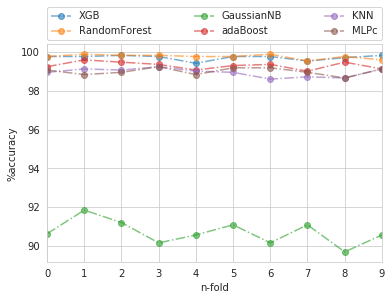

In [120]:
mod_stats(d_dic, 'dos')

> ## Probe

In [121]:
X_train, y_train, X_test, y_test = get_test_train(probe_train, probe_test, probe_uf )
print('Train Size:\n  {}\n Test Size:\n  {}\n'.format(X_train.shape, X_test.shape))

Train Size:
  (78999, 18)
 Test Size:
  (12132, 18)



In [122]:
clf_probe=DecisionTreeClassifier(random_state=101)
clf_probe.fit(X_train, y_train)
y_pred=clf_probe.predict(X_test)
# Create confusion matrix
pd.crosstab(y_test, y_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,2
Actual attacks,,
0,8369,1342
2,1133,1288


In [123]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      9711
           2       0.49      0.53      0.51      2421

    accuracy                           0.80     12132
   macro avg       0.69      0.70      0.69     12132
weighted avg       0.80      0.80      0.80     12132



In [124]:
# Didn't changed the variable names. Just made them correct.
# Will make func
dos_X, dos_Y = X_test, y_test
t0 = time()
print("Initiating Build #1!")
print("1%..", end ="")
d_xgb = skfold(dos_X, dos_Y, xgboost.XGBClassifier())
print("15%..", end ="")
d_gnb = skfold(dos_X, dos_Y, GaussianNB())
print("30%..", end ="")
d_rf = skfold(dos_X, dos_Y, RandomForestClassifier())
print("45%..", end ="")
#d_svc = skfold(dos_X, dos_Y, SVC())
print("60%..", end ="")
d_ada = skfold(dos_X, dos_Y, AdaBoostClassifier())
print("75%..", end ="")
d_knn = skfold(dos_X, dos_Y, KNeighborsClassifier())
print("90%..", end ="")
d_MLPc = skfold(dos_X, dos_Y, MLPClassifier())
print("100%!")
print("Time taken {} seconds\n".format(time() - t0))
d_dic = {'XGB': d_xgb, 'RandomForest': d_rf, # 'SVC': d_svc,
         'GaussianNB': d_gnb, 'adaBoost': d_ada, 'KNN': d_knn, 'MLPc': d_MLPc}
d_dic

Initiating Build #1!
1%..15%..30%..

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

45%..60%..75%..90%..

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


100%!
Time taken 118.2907485961914 seconds



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'GaussianNB': array([0.97283951, 0.95960429, 0.97114592, 0.97279472, 0.97526793,
        0.96784831, 0.96619951, 0.95877988, 0.96949711, 0.96702391]),
 'KNN': array([0.98847737, 0.98680956, 0.98763397, 0.98680956, 0.98928277,
        0.98598516, 0.98680956, 0.98598516, 0.98680956, 0.98433636]),
 'MLPc': array([0.98683128, 0.98268755, 0.99010717, 0.98763397, 0.98928277,
        0.98433636, 0.98516076, 0.98598516, 0.99175598, 0.98433636]),
 'RandomForest': array([0.99506173, 0.99175598, 0.99752679, 0.99505359, 0.99505359,
        0.99587799, 0.99175598, 0.99505359, 0.99505359, 0.99340478]),
 'XGB': array([0.99341564, 0.99010717, 0.99422918, 0.99093157, 0.99587799,
        0.9983512 , 0.99258038, 0.99175598, 0.99422918, 0.99175598]),
 'adaBoost': array([0.98600823, 0.98021434, 0.99093157, 0.98763397, 0.99093157,
        0.99587799, 0.98516076, 0.98598516, 0.98598516, 0.99010717])}

Accuracy of XGB is 99.33234269352249 and std is 0.2344881758155417
Accuracy of RandomForest is 99.45597589895476 and std is 0.1697787244814388
Accuracy of GaussianNB is 96.81001089025271 and std is 0.5205641456473235
Accuracy of adaBoost is 98.78835930370234 and std is 0.4055288337588719
Accuracy of KNN is 98.68939031547808 and std is 0.1303182928684142
Accuracy of MLPc is 98.68117343321154 and std is 0.2734240891957512
         XGB  RandomForest  GaussianNB   adaBoost        KNN       MLPc
0  99.341564     99.506173   97.283951  98.600823  98.847737  98.683128
1  99.010717     99.175598   95.960429  98.021434  98.680956  98.268755
2  99.422918     99.752679   97.114592  99.093157  98.763397  99.010717
3  99.093157     99.505359   97.279472  98.763397  98.680956  98.763397
4  99.587799     99.505359   97.526793  99.093157  98.928277  98.928277
5  99.835120     99.587799   96.784831  99.587799  98.598516  98.433636
6  99.258038     99.175598   96.619951  98.516076  98.680956  98.516076


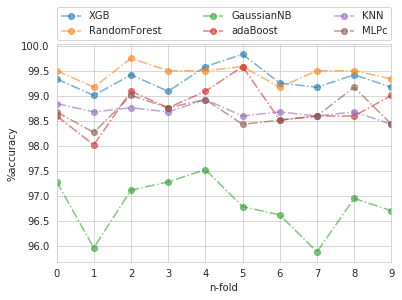

In [135]:
mod_stats(d_dic, 'probe ')

> ## R2L

In [137]:
X_train, y_train, X_test, y_test = get_test_train(r2l_train, r2l_test, r2l_uf )
print('Train Size:\n  {}\n Test Size:\n  {}\n'.format(X_train.shape, X_test.shape))

Train Size:
  (68338, 18)
 Test Size:
  (12596, 18)



In [127]:
clf_r=DecisionTreeClassifier(random_state=101)
clf_r.fit(X_train, y_train)
y_pred=clf_r.predict(X_test)
# Create confusion matrix
pd.crosstab(y_test, y_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,3
Actual attacks,,
0,9675,36
3,2867,18


In [128]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      9711
           3       0.33      0.01      0.01      2885

    accuracy                           0.77     12596
   macro avg       0.55      0.50      0.44     12596
weighted avg       0.67      0.77      0.67     12596



In [138]:
dos_X, dos_Y = X_test, y_test
t0 = time()
print("Initiating Build #1!")
print("1%..", end ="")
d_xgb = skfold(dos_X, dos_Y, xgboost.XGBClassifier())
print("15%..", end ="")
d_gnb = skfold(dos_X, dos_Y, GaussianNB())
print("30%..", end ="")
d_rf = skfold(dos_X, dos_Y, RandomForestClassifier())
print("45%..", end ="")
#d_svc = skfold(dos_X, dos_Y, SVC())
print("60%..", end ="")
d_ada = skfold(dos_X, dos_Y, AdaBoostClassifier())
print("75%..", end ="")
d_knn = skfold(dos_X, dos_Y, KNeighborsClassifier())
print("90%..", end ="")
d_MLPc = skfold(dos_X, dos_Y, MLPClassifier())
print("100%!")
print("Time taken {} seconds\n".format(time() - t0))
d_dic = {'XGB': d_xgb, 'RandomForest': d_rf, # 'SVC': d_svc,
         'GaussianNB': d_gnb, 'adaBoost': d_ada, 'KNN': d_knn, 'MLPc': d_MLPc}
d_dic

Initiating Build #1!
1%..15%..30%..

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

45%..60%..75%..90%..

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

100%!
Time taken 137.26943373680115 seconds



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'GaussianNB': array([0.8445678 , 0.85238095, 0.84761905, 0.86428571, 0.86190476,
        0.85941223, 0.86338364, 0.86020651, 0.84114376, 0.85702939]),
 'KNN': array([0.96272799, 0.96031746, 0.95793651, 0.96269841, 0.96349206,
        0.96981732, 0.97220016, 0.96505163, 0.95949166, 0.95472597]),
 'MLPc': array([0.94290246, 0.94285714, 0.94126984, 0.93968254, 0.94365079,
        0.9451946 , 0.94440032, 0.93804607, 0.93725179, 0.94201747]),
 'RandomForest': array([0.97620936, 0.97380952, 0.97380952, 0.97698413, 0.97777778,
        0.9872915 , 0.98490866, 0.98649722, 0.97776013, 0.97299444]),
 'XGB': array([0.96907216, 0.97063492, 0.97460317, 0.96269841, 0.97619048,
        0.97855441, 0.97220016, 0.96822875, 0.97220016, 0.96266878]),
 'adaBoost': array([0.95876289, 0.96746032, 0.97222222, 0.95555556, 0.96666667,
        0.96822875, 0.97140588, 0.96108022, 0.95552025, 0.95154885])}

Accuracy of XGB is 97.07051412776788 and std is 0.49885817686424044
Accuracy of RandomForest is 97.88042256022489 and std is 0.5141183099815947
Accuracy of GaussianNB is 85.51933815660959 and std is 0.7852830566996469
Accuracy of adaBoost is 96.28451604022953 and std is 0.6930231204743912
Accuracy of KNN is 96.28459173604644 and std is 0.4990996766552594
Accuracy of MLPc is 94.17273022053857 and std is 0.2521522390560044
         XGB  RandomForest  GaussianNB   adaBoost        KNN       MLPc
0  96.907216     97.620936   84.456780  95.876289  96.272799  94.290246
1  97.063492     97.380952   85.238095  96.746032  96.031746  94.285714
2  97.460317     97.380952   84.761905  97.222222  95.793651  94.126984
3  96.269841     97.698413   86.428571  95.555556  96.269841  93.968254
4  97.619048     97.777778   86.190476  96.666667  96.349206  94.365079
5  97.855441     98.729150   85.941223  96.822875  96.981732  94.519460
6  97.220016     98.490866   86.338364  97.140588  97.220016  94.440032

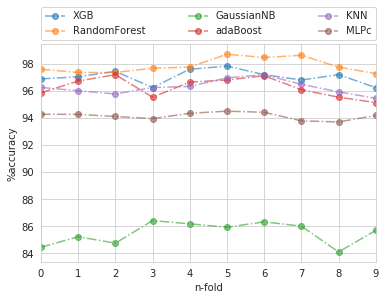

In [139]:
mod_stats(d_dic, 'r2l')

> ## U2R

In [142]:
X_train, y_train, X_test, y_test = get_test_train(u2r_train, u2r_test, u2r_uf )
print('Train Size:\n  {}\n Test Size:\n  {}\n'.format(X_train.shape, X_test.shape))

Train Size:
  (67395, 19)
 Test Size:
  (9778, 19)



In [133]:
clf_r=DecisionTreeClassifier(random_state=101)
clf_r.fit(X_train, y_train)
y_pred=clf_r.predict(X_test)
# Create confusion matrix
pd.crosstab(y_test, y_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,4
Actual attacks,,
0,9701,10
4,57,10


In [134]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9711
           4       0.50      0.15      0.23        67

    accuracy                           0.99      9778
   macro avg       0.75      0.57      0.61      9778
weighted avg       0.99      0.99      0.99      9778



In [148]:
dos_X, dos_Y = X_test, y_test
t0 = time()
print("Initiating Build #1!")
print("1%..", end ="")
d_xgb = skfold(dos_X, dos_Y, xgboost.XGBClassifier())
print("15%..", end ="")
d_gnb = skfold(dos_X, dos_Y, GaussianNB())
print("30%..", end ="")
d_rf = skfold(dos_X, dos_Y, RandomForestClassifier())
print("45%..", end ="")
#d_svc = skfold(dos_X, dos_Y, SVC())
print("60%..", end ="")
d_ada = skfold(dos_X, dos_Y, AdaBoostClassifier())
print("75%..", end ="")
d_knn = skfold(dos_X, dos_Y, KNeighborsClassifier())
print("90%..", end ="")
d_MLPc = skfold(dos_X, dos_Y, MLPClassifier())
print("100%!")
print("Time taken {} seconds\n".format(time() - t0))
d_dic = {'XGB': d_xgb, 'RandomForest': d_rf, # 'SVC': d_svc,
         'GaussianNB': d_gnb, 'adaBoost': d_ada, 'KNN': d_knn, 'MLPc': d_MLPc}
d_dic

Initiating Build #1!
1%..15%..30%..

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

45%..60%..75%..90%..100%!
Time taken 55.75341057777405 seconds



{'GaussianNB': array([0.98876404, 0.9805726 , 0.98261759, 0.98773006, 0.93762781,
        0.98159509, 0.97750511, 0.9825998 , 0.98055271, 0.98362334]),
 'KNN': array([0.9938713 , 0.99693252, 0.99284254, 0.99386503, 0.99488753,
        0.99488753, 0.99693252, 0.99692938, 0.99692938, 0.99897646]),
 'MLPc': array([0.99489275, 0.99693252, 0.99693252, 0.99795501, 0.99795501,
        0.99897751, 0.99897751, 0.99590583, 0.99692938, 0.99692938]),
 'RandomForest': array([0.9959142 , 0.99488753, 0.99591002, 0.99795501, 0.99897751,
        0.99795501, 0.99591002, 0.99795292, 0.99692938, 0.99795292]),
 'XGB': array([0.99897855, 0.99488753, 0.99693252, 0.99591002, 0.99795501,
        0.99795501, 0.99693252, 0.99897646, 0.99590583, 0.99897646]),
 'adaBoost': array([0.9959142 , 0.99591002, 0.99795501, 0.99693252, 0.99591002,
        0.99795501, 0.99693252, 0.99795292, 0.99590583, 0.99590583])}

Accuracy of XGB is 99.73409897956789 and std is 0.13872885267571974
Accuracy of RandomForest is 99.713628129119 and std is 0.15031397173919978
Accuracy of GaussianNB is 97.83188151124212 and std is 1.3927821941855236
Accuracy of adaBoost is 99.67273875651641 and std is 0.08914901646586586
Accuracy of KNN is 99.57054155329838 and std is 0.18163810646402168
Accuracy of MLPc is 99.74431342002349 and std is 0.09430364205668597
         XGB  RandomForest  GaussianNB   adaBoost        KNN       MLPc
0  99.897855     99.795710   98.876404  99.591420  99.387130  99.693565
1  99.488753     99.591002   98.057260  99.591002  99.693252  99.591002
2  99.693252     99.386503   98.261759  99.795501  99.284254  99.693252
3  99.591002     99.693252   98.773006  99.693252  99.386503  99.795501
4  99.795501     99.897751   93.762781  99.591002  99.488753  99.795501
5  99.795501     99.897751   98.159509  99.795501  99.488753  99.897751
6  99.693252     99.795501   97.750511  99.693252  99.693252  99.8977

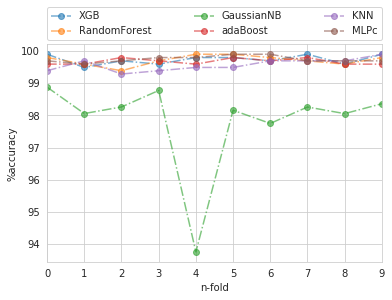

In [145]:
mod_stats(d_dic,'U2R')

## Combining the best model for final Intrusion Detection.
Based on the previous work, select the model which excels in detecting a particular attack. Using this N models are used to deceide which attack it is..